$$
\begin{align*}
\text{1D Heat Diffusion: }
\frac{du(x,t)}{dt} &= \alpha \frac{d^2u(x,t)}{dx^2} + f(x,t)
\end{align*}
$$


Evaluating for length scale l=0.001
normal MSE with l=0.001: 4.925987648269781e-05
Evaluating for length scale l=0.01
normal MSE with l=0.01: 4.925987648269781e-05
Evaluating for length scale l=0.1
normal MSE with l=0.1: 4.925987648269781e-05
Evaluating for length scale l=1
normal MSE with l=1: 3.306162822174517e-06
Evaluating for length scale l=1.5
normal MSE with l=1.5: 9.052234517839024e-07
Evaluating for length scale l=2
normal MSE with l=2: 9.56643130113299e-05
Optimal l for normal: 1.5 with MSE: 9.052234517839024e-07


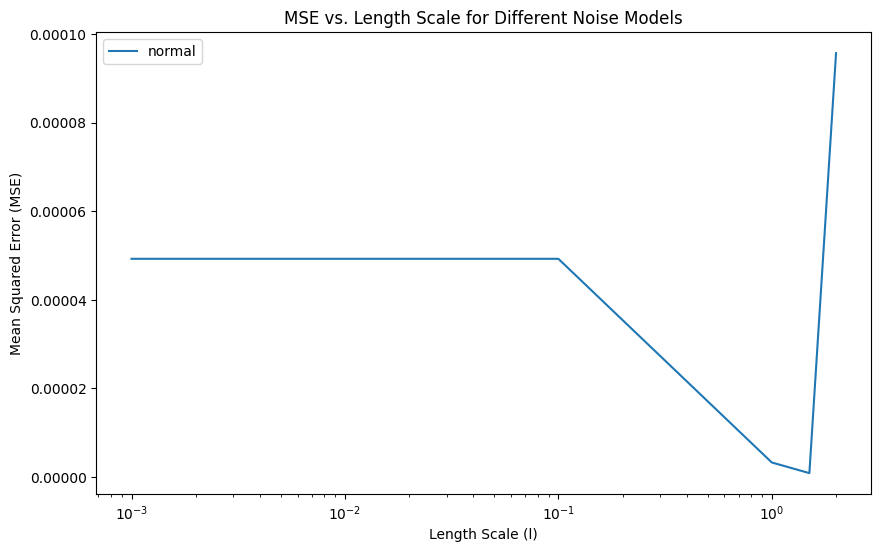

normal MSEs: [4.925987648269781e-05, 4.925987648269781e-05, 4.925987648269781e-05, 3.306162822174517e-06, 9.052234517839024e-07, 9.56643130113299e-05]


<Figure size 1500x500 with 0 Axes>

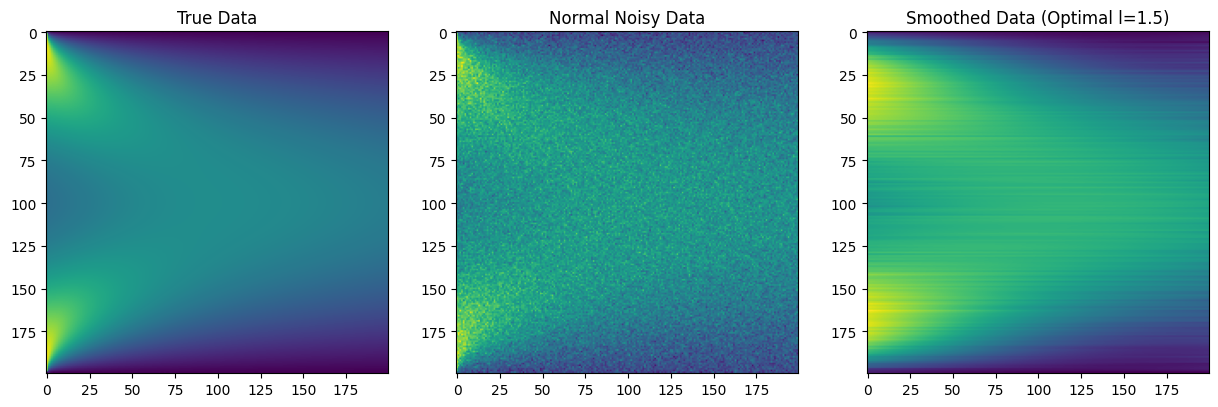

In [8]:
from derivatives import (
    first_derivative,
    second_derivative,
)
from scipy.integrate import solve_ivp
from scipy.linalg import solve
from sklearn.gaussian_process import kernels
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.metrics import mean_squared_error

a = 0.005
L = 1
Nx = 200
dx = L / (Nx - 1)
x = np.linspace(0, L, Nx)
# u0 = np.exp((-np.sin(np.pi * x) ** 2) / 2)
u0 = np.exp((-np.sin(np.pi * x) ** 2))
t_span = (0, 10)
t_eval = np.linspace(0, 10, 200)

def diffusion(t, u, a, dx):
    u[0] = 0
    u[-1] = 0
    uxx = second_derivative(u, dx)
    ut = a * uxx + a * u ** 2
    return np.array(ut)

u_diff = solve_ivp(diffusion, t_span=t_span, y0=u0, args=(a, dx), t_eval=t_eval).y.T
m, n = u_diff.shape

u_diff_noisy_normal = u_diff + np.random.normal(scale=0.1, size=(m, n))
# u_diff_noisy_uniform = u_diff + np.random.uniform(size=(m, n))
# u_diff_noisy_poisson = u_diff + np.random.poisson(lam=0.01, size=(m, n))
# u_diff_noisy_laplace = u_diff + np.random.laplace(scale=1, size=(m, n))
# u_diff_noisy_exponential = u_diff + np.random.exponential(scale=0.1, size=(m, n))

noisy_data = {
    "normal": u_diff_noisy_normal,
    # "uniform": u_diff_noisy_uniform,
    # "poisson": u_diff_noisy_poisson,
    # "laplace": u_diff_noisy_laplace,
    # "exponential": u_diff_noisy_exponential,
}

# l_values = [0.01, 0.1, 1, 10, 50]
l_values = [0.001, 0.01, 0.1, 1, 1.5, 2]

def rbf_kernel_derivative(x1, x2, length_scale, order=1):
    rbf = kernels.RBF(length_scale=length_scale)
    K = rbf(x1, x2)
    if order == 1:
        return -(x1[:, None, :] - x2[None, :, :]) / (length_scale ** 2) * K[:, :, None]
    elif order == 2:
        return ((x1[:, None, :] - x2[None, :, :]) ** 2 - length_scale ** 2) / (length_scale ** 4) * K[:, :, None]
    else:
        raise ValueError("Higher order derivatives not implemented")

def calculate_mse(f, f_new):
    return mean_squared_error(f, f_new)

def P(S, s, P_coef, rbf):
    K_sS = rbf(S, s)
    return K_sS @ P_coef

def smooth_and_evaluate(u_diff_noisy, l):
    rbf = kernels.RBF(length_scale=l)
    u_rbf = rbf(x[:, None], x[:, None])
    u_diff_smooth = u_rbf @ solve((u_rbf + 0.1 * np.eye(Nx)), u_diff_noisy)
    
    f = np.cos(2 * np.pi * x)
    SS = np.random.random((200, 600))
    
    u_kx = rbf_kernel_derivative(x[:, None], x[:, None], length_scale=l, order=1).squeeze() @ solve(
        (u_rbf + 0.1 * np.eye(Nx)), u_diff_smooth
    )
    u_kxx = rbf_kernel_derivative(x[:, None], x[:, None], length_scale=l, order=2).squeeze() @ solve(
        (u_rbf + 0.1 * np.eye(Nx)), u_diff_smooth
    )
    s = np.hstack([u_diff_smooth, u_kx, u_kxx])
    K = rbf(s, s)
    P_coef = solve((K + 0.01 * np.eye(Nx)), f)
    f_new = P(s, s, P_coef, rbf)
    
    return calculate_mse(f, f_new), u_diff_smooth

#CROSS VALIDATION
mse_results = {noise_type: [] for noise_type in noisy_data.keys()}
smooth_data_results = {noise_type: {} for noise_type in noisy_data.keys()}

for l in l_values:
    print(f"Evaluating for length scale l={l}")
    for noise_type, u_diff_noisy in noisy_data.items():
        mse, u_diff_smooth = smooth_and_evaluate(u_diff_noisy, l)
        mse_results[noise_type].append(mse)
        smooth_data_results[noise_type][l] = u_diff_smooth
        print(f"{noise_type} MSE with l={l}: {mse}")

optimal_l = {}
optimal_smooth_data = {}
for noise_type, mses in mse_results.items():
    min_mse = min(mses)
    optimal_l_value = l_values[mses.index(min_mse)]
    optimal_l[noise_type] = optimal_l_value
    optimal_smooth_data[noise_type] = smooth_data_results[noise_type][optimal_l_value]
    print(f"Optimal l for {noise_type}: {optimal_l_value} with MSE: {min_mse}")

plt.figure(figsize=(10, 6))
for noise_type, mses in mse_results.items():
    plt.plot(l_values, mses, label=noise_type)
plt.xscale('log')
plt.xlabel('Length Scale (l)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Length Scale for Different Noise Models')
plt.legend()
plt.show()

for noise_type, mses in mse_results.items():
    print(f"{noise_type} MSEs: {mses}")

for noise_type, u_diff_noisy in noisy_data.items():
    optimal_l_value = optimal_l[noise_type]
    u_diff_smooth = optimal_smooth_data[noise_type]
    
    plt.figure(figsize=(15, 5))
    fig, axis = plt.subplots(1, 3, figsize=(15, 5))
    axis[0].imshow(u_diff.T)
    axis[0].set_title('True Data')
    axis[1].imshow(u_diff_noisy.T)
    axis[1].set_title(f'{noise_type.capitalize()} Noisy Data')
    axis[2].imshow(u_diff_smooth.T)
    axis[2].set_title(f'Smoothed Data (Optimal l={optimal_l_value})')
    plt.show()
